### #1

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from mocap.test import (
    CAMERAS_NB,
    K_DEFAULT,
    PATTERN,
    read_config,
    detect_markers,
    find_corresponding_points,
    find_camera_position,
    calculate_projection_matrix,
    calculate_error,
    n_view_traingulation,
    get_pattern_inner_dims,
    calculate_inner_errors
)

cameras_nb = CAMERAS_NB
pattern_points = PATTERN
K = K_DEFAULT
compute_projection_matrix = calculate_projection_matrix
cameras = {151: {}, 127: {}, 135: {}, 143: {}}
no2id = {
    1: 151,
    2: 127,
    3: 135,
    4: 143
}
id2no = {
    151: 1,
    127: 2,
    135: 3,
    143: 4
}
config = read_config("configs/config.yaml")
np.set_printoptions(formatter={"float": lambda x: "{:11.6f}".format(x)})


def get_camera_params():
    
    for ci in range(cameras_nb):
        
        camera = {}
        cam_id = list(cameras.keys())[ci]
        print("#"*128, "\nCAMERA ID:", cam_id, end="\n\n")
        print("#"*64, "CALIBRATION", "#"*64, sep="\n", end="\n\n")
        
        image = cv2.imread(f"recorded_data/detections/exter_calibration/camera_{id2no[cam_id]}.jpg") # *.bmp, *.jpg
        print("IMG SHAPE:", image.shape)
        objs = detect_markers(image, config["DETECTION"])
        objs = np.array(objs)
        markers = np.zeros((objs.shape[0], objs.shape[1]))
        markers[:, 1:] = objs[:, :2]
        print("MARKERS SHAPE:", np.array(markers).shape)
        print("OBJS:")
        print(np.array(markers)[:, 1:])
        print("")
        
        sorted_markers = find_corresponding_points(markers)
        # camera["markers"] = sorted_markers
        
        print("SORTED:")
        print(np.array(sorted_markers)[:,1:])
        print("")
        
        img = image.copy()
        for idx, x, y in sorted_markers:
            cv2.circle(img, (int(x), int(y)), 5, (255,0,0), 4)
            cv2.putText(img, f"{idx+1}", (int(x)+10, int(y-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
        plt.imshow(img)
        plt.show()

        img_points = np.array([[x, y] for _, x, y in sorted_markers], dtype='double')
        obj_points = np.array([pattern_points[id] for id, _, _ in sorted_markers], dtype='double')

        r_mat, t_vec = find_camera_position(img_points, obj_points, K)
        camera["R"] = r_mat
        camera["t"] = t_vec

        P = compute_projection_matrix(r_mat, t_vec, K)
        camera["P"] = P

        cameras[cam_id] = camera
        
        calculate_error(img_points, obj_points, P)
        
        np.save(f"recorded_data/detections/P_{cam_id}.npy", P)
        print(f"FOR [{cam_id}] SAVED: OK\n\n")
        
        print("#"*64, "DETECTION", "#"*64, sep="\n", end="\n\n")
        
        # image = cv2.imread(f"recorded_data/detections/imgs/im_{cam_id}_0.bmp")
        image = cv2.imread(f"recorded_data/detections/imgs/camera_{id2no[cam_id]}.bmp") # *.bmp, *.jpg
        print("IMG SHAPE:", image.shape)
        objs = detect_markers(image, config["DETECTION"])
        objs = np.array(objs)
        markers = np.zeros((objs.shape[0], objs.shape[1]))
        markers[:, 1:] = objs[:, :2]
        print("MARKERS SHAPE:", np.array(markers).shape)
        print("OBJS:")
        print(np.array(markers)[:, 1:])
        print("")
        
        sorted_markers = find_corresponding_points(markers)
        camera["markers"] = sorted_markers
        
        print("SORTED:")
        print(np.array(sorted_markers)[:,1:])
        print("")
        
        img = image.copy()
        for idx, x, y in sorted_markers:
            cv2.circle(img, (int(x), int(y)), 5, (255,0,0), 4)
            cv2.putText(img, f"{idx+1}", (int(x)+10, int(y-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
        plt.imshow(img)
        plt.show()
        
        img_points = np.array([[x, y] for _, x, y in sorted_markers], dtype='double')
        obj_points = np.array([pattern_points[id] for id, _, _ in sorted_markers], dtype='double')


def get_pose_from_cameras():
    
    fig, ax = plt.subplots(1,1)
    estim_p = []
    for i, marker in enumerate(pattern_points.values()):
        points = []
        P_vec = []

        for ci, cam in cameras.items():
            P_vec.append(cam["P"])  
            point = (cam["markers"][i][1], cam["markers"][i][2])      
            points.append(point)

        rec = n_view_traingulation(P_vec, points)
        rec = rec[:-1]
        estim_p.append(rec)
        # print(rec)
        ax.scatter(rec[0], rec[1])
    
    print("#"*64, "\nRecreate pattern\n")
    plt.show()
    print("\nCOORDINATES:\n")
    for pt in estim_p:
        print(pt)
    print("\nINNER DIMS:\n")
    for idx, *item in get_pattern_inner_dims([(idx, *item) for idx, item in enumerate(estim_p)]):
        print(idx, ":", *item)
    print("\nERRORS:\n")
    pattern_as_list = [item for key, item in pattern_points.items()]
    print(calculate_inner_errors(estim_p, pattern_as_list))
    print("\nMSE:\n")
    for idx, err in enumerate(calculate_inner_errors(estim_p, pattern_as_list)):
        print(idx, ":", np.power(err,2).sum())

################################################################################################################################ 
CAMERA ID: 151

################################################################
CALIBRATION
################################################################

IMG SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
OBJS:
[[ 707.363636  835.454545]
 [ 660.000000  857.500000]
 [ 738.500000  872.714286]
 [ 610.285714  880.500000]
 [ 773.636364  914.090909]
 [ 673.600000  965.600000]]

SORTED:
[[ 707.363636  835.454545]
 [ 660.000000  857.500000]
 [ 610.285714  880.500000]
 [ 673.600000  965.600000]
 [ 773.636364  914.090909]
 [ 738.500000  872.714286]]



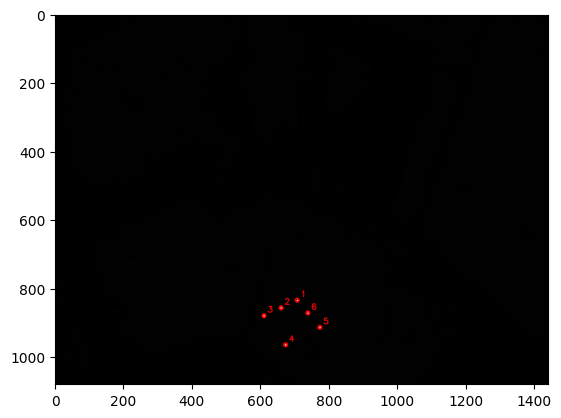

Sum of squred errors of reproductions is: 54.78998355006001

point:		[ 707.363636  835.454545]
projection:	[ 708.277490  831.066004]
error: 		[  -0.913853    4.388541]

point:		[ 660.000000  857.500000]
projection:	[ 658.550513  857.597828]
error: 		[   1.449487   -0.097828]

point:		[ 610.285714  880.500000]
projection:	[ 610.553465  883.206648]
error: 		[  -0.267751   -2.706648]

point:		[ 673.600000  965.600000]
projection:	[ 674.952733  963.364218]
error: 		[  -1.352733    2.235782]

point:		[ 773.636364  914.090909]
projection:	[ 770.834139  916.162420]
error: 		[   2.802225   -2.071511]

point:		[ 738.500000  872.714286]
projection:	[ 740.220524  874.518423]
error: 		[  -1.720524   -1.804137]

FOR [151] SAVED: OK


################################################################
DETECTION
################################################################

IMG SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
OBJS:
[[ 758.000000  944.714286]
 [ 703.166667  948.833333]
 [ 652.500000  952.

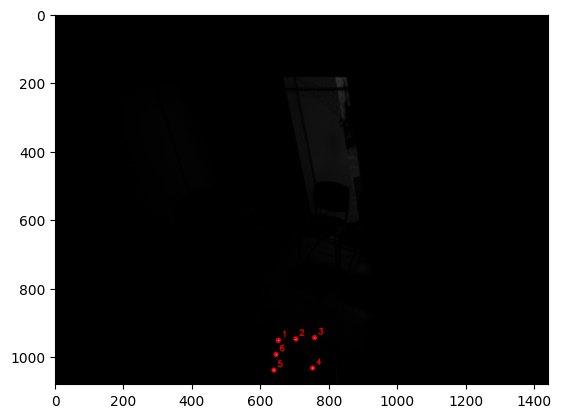

################################################################################################################################ 
CAMERA ID: 127

################################################################
CALIBRATION
################################################################

IMG SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
OBJS:
[[ 882.769231  800.153846]
 [ 845.000000  827.307692]
 [ 807.266667  853.666667]
 [ 964.812500  866.187500]
 [ 847.588235  889.117647]
 [ 890.250000  926.250000]]

SORTED:
[[ 807.266667  853.666667]
 [ 847.588235  889.117647]
 [ 890.250000  926.250000]
 [ 964.812500  866.187500]
 [ 882.769231  800.153846]
 [ 845.000000  827.307692]]



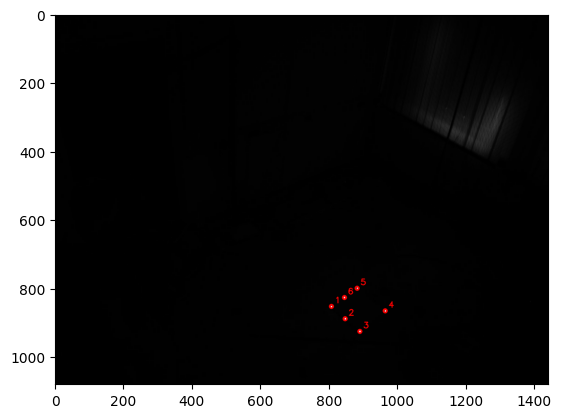

Sum of squred errors of reproductions is: 43.48568926635058

point:		[ 807.266667  853.666667]
projection:	[ 809.723178  856.084079]
error: 		[  -2.456512   -2.417412]

point:		[ 847.588235  889.117647]
projection:	[ 848.450180  889.765176]
error: 		[  -0.861945   -0.647529]

point:		[ 890.250000  926.250000]
projection:	[ 887.773028  923.964484]
error: 		[   2.476972    2.285516]

point:		[ 964.812500  866.187500]
projection:	[ 965.963576  868.486885]
error: 		[  -1.151076   -2.299385]

point:		[ 882.769231  800.153846]
projection:	[ 881.414920  796.950970]
error: 		[   1.354311    3.202876]

point:		[ 845.000000  827.307692]
projection:	[ 844.406016  827.476823]
error: 		[   0.593984   -0.169130]

FOR [127] SAVED: OK


################################################################
DETECTION
################################################################

IMG SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
OBJS:
[[ 752.875000  925.875000]
 [ 869.000000  932.000000]
 [ 747.636364  973.

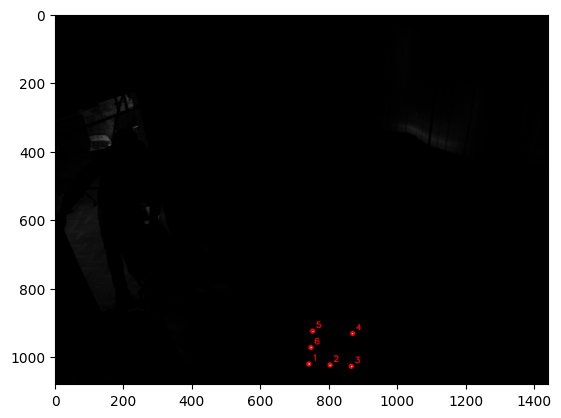

################################################################################################################################ 
CAMERA ID: 135

################################################################
CALIBRATION
################################################################

IMG SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
OBJS:
[[ 658.166667  468.166667]
 [ 734.875000  518.125000]
 [ 582.500000  528.500000]
 [ 697.833333  549.833333]
 [ 621.000000  555.500000]
 [ 659.285714  583.000000]]

SORTED:
[[ 659.285714  583.000000]
 [ 697.833333  549.833333]
 [ 734.875000  518.125000]
 [ 658.166667  468.166667]
 [ 582.500000  528.500000]
 [ 621.000000  555.500000]]



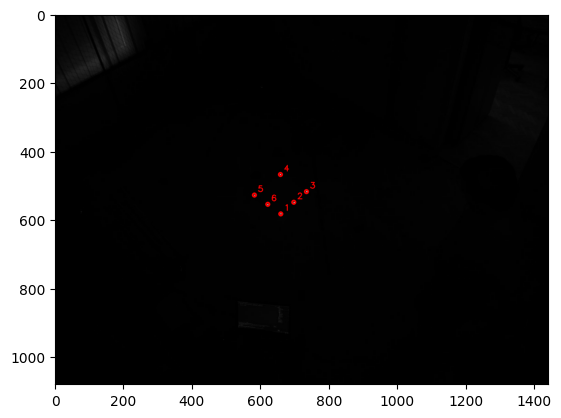

Sum of squred errors of reproductions is: 143.17943286112515

point:		[ 659.285714  583.000000]
projection:	[ 661.209126  590.137652]
error: 		[  -1.923411   -7.137652]

point:		[ 697.833333  549.833333]
projection:	[ 698.755982  547.779782]
error: 		[  -0.922648    2.053551]

point:		[ 734.875000  518.125000]
projection:	[ 727.974327  514.817584]
error: 		[   6.900673    3.307416]

point:		[ 658.166667  468.166667]
projection:	[ 660.684478  469.105338]
error: 		[  -2.517811   -0.938671]

point:		[ 582.500000  528.500000]
projection:	[ 584.062154  524.638153]
error: 		[  -1.562154    3.861847]

point:		[ 621.000000  555.500000]
projection:	[ 620.423413  555.509673]
error: 		[   0.576587   -0.009673]

FOR [135] SAVED: OK


################################################################
DETECTION
################################################################

IMG SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
OBJS:
[[ 916.125000  930.875000]
 [1025.125000  970.125000]
 [1007.000000 1014

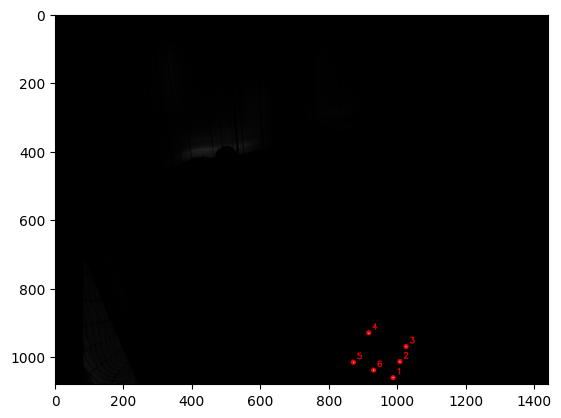

################################################################################################################################ 
CAMERA ID: 143

################################################################
CALIBRATION
################################################################

IMG SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
OBJS:
[[ 658.000000  904.200000]
 [ 695.875000  940.875000]
 [ 568.090909  954.636364]
 [ 734.000000  978.800000]
 [ 692.000000 1006.500000]
 [ 644.384615 1036.615385]]

SORTED:
[[ 734.000000  978.800000]
 [ 695.875000  940.875000]
 [ 658.000000  904.200000]
 [ 568.090909  954.636364]
 [ 644.384615 1036.615385]
 [ 692.000000 1006.500000]]



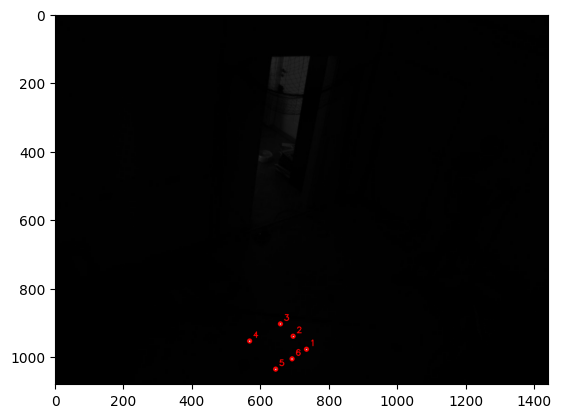

Sum of squred errors of reproductions is: 55.272992976790384

point:		[ 734.000000  978.800000]
projection:	[ 734.644812  980.887822]
error: 		[  -0.644812   -2.087822]

point:		[ 695.875000  940.875000]
projection:	[ 696.781466  941.321872]
error: 		[  -0.906466   -0.446872]

point:		[ 658.000000  904.200000]
projection:	[ 657.615198  900.394412]
error: 		[   0.384802    3.805588]

point:		[ 568.090909  954.636364]
projection:	[ 568.861897  958.107690]
error: 		[  -0.770988   -3.471326]

point:		[ 644.384615 1036.615385]
projection:	[ 645.395443 1033.293348]
error: 		[  -1.010828    3.322037]

point:		[ 692.000000 1006.500000]
projection:	[ 689.036894 1007.667921]
error: 		[   2.963106   -1.167921]

FOR [143] SAVED: OK


################################################################
DETECTION
################################################################

IMG SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
OBJS:
[[ 903.111111  837.666667]
 [ 958.000000  842.000000]
 [1012.714286  847

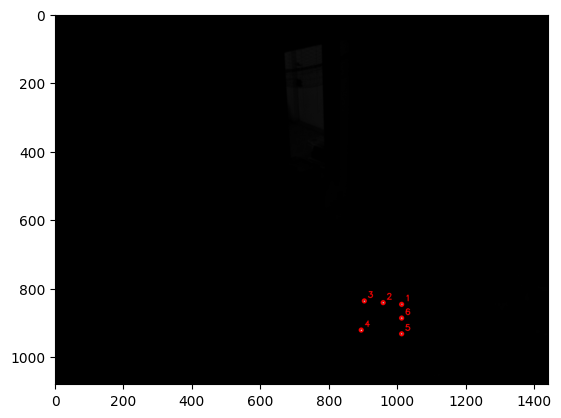

################################################################ 
Recreate pattern



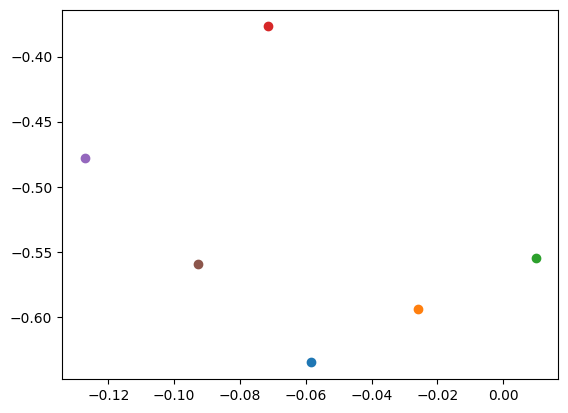


COORDINATES:

[  -0.058355   -0.634788    0.164506]
[  -0.025946   -0.593740    0.172796]
[   0.009851   -0.554304    0.188327]
[  -0.071373   -0.376956    0.179518]
[  -0.127200   -0.477994    0.169454]
[  -0.092638   -0.559301    0.164567]

INNER DIMS:

0 : [0.0, 0.052952529838034834, 0.10815369531187347, 0.25859606931112705, 0.17131392550601107, 0.08290720155044529]
1 : [0.052952529838034834, 0.0, 0.055478723234937875, 0.22159450172133577, 0.15382058599600168, 0.0755094205485316]
2 : [0.10815369531187347, 0.055478723234937875, 0.0, 0.19526155699224396, 0.15799485259985444, 0.10532642673598233]
3 : [0.25859606931112705, 0.22159450172133577, 0.19526155699224396, 0.0, 0.11587264560756268, 0.18418843756793712]
4 : [0.17131392550601107, 0.15382058599600168, 0.15799485259985444, 0.11587264560756268, 0.0, 0.08848307077610718]
5 : [0.08290720155044529, 0.0755094205485316, 0.10532642673598233, 0.18418843756793712, 0.08848307077610718, 0.0]

ERRORS:

[[   0.000000    0.122047    0.241846    

In [2]:
get_camera_params()
get_pose_from_cameras()

### #2

In [3]:
from mocap.test import PATTERN, dict_to_list, get_pattern_inner_dims, get_inner_error_matrix

np.set_printoptions(formatter={"float": lambda x: "{:11.6f}".format(x)})

pattern_as_list = dict_to_list(PATTERN)
for item in pattern_as_list:
    print(np.array(item))
print("")

for item in get_pattern_inner_dims(pattern_as_list):
    print(f"{item[0]} : {np.array(item[1:][0])}")

print("")
print(get_inner_error_matrix(get_pattern_inner_dims(pattern_as_list)))

[   0.000000    0.000000    0.000000    0.000000]
[   1.000000    0.175000    0.000000    0.000000]
[   2.000000    0.350000    0.000000    0.000000]
[   3.000000    0.350000    0.350000    0.000000]
[   4.000000    0.000000    0.350000    0.000000]
[   5.000000    0.000000    0.175000    0.000000]

0 : [   0.000000    0.175000    0.350000    0.494975    0.350000    0.175000]
1 : [   0.175000    0.000000    0.175000    0.391312    0.391312    0.247487]
2 : [   0.350000    0.175000    0.000000    0.350000    0.494975    0.391312]
3 : [   0.494975    0.391312    0.350000    0.000000    0.350000    0.391312]
4 : [   0.350000    0.391312    0.494975    0.350000    0.000000    0.175000]
5 : [   0.175000    0.247487    0.391312    0.391312    0.175000    0.000000]

[[   0.000000    0.175000    0.350000    0.494975    0.350000    0.175000]
 [   0.175000    0.000000    0.175000    0.391312    0.391312    0.247487]
 [   0.350000    0.175000    0.000000    0.350000    0.494975    0.391312]
 [   

### #3

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from mocap.test import (
    CAMERAS_NB,
    PATTERN,
    read_config,
    detect_markers,
    find_corresponding_points,
    get_pattern_inner_dims,
    calculate_inner_errors
)
cameras_nb = CAMERAS_NB
pattern_points = PATTERN
pattern_pnb = len(list(pattern_points.keys()))
cameras = {151: {}, 127: {}, 135: {}, 143: {}}
no2id = {
    1: 151,
    2: 127,
    3: 135,
    4: 143
}
id2no = {
    151: 1,
    127: 2,
    135: 3,
    143: 4
}
config = read_config("configs/config.yaml")
np.set_printoptions(formatter={"float": lambda x: "{:11.6f}".format(x)})


def get_camera_params():
    
    print(f"{'#'*128}\nCALIBRATION\n")
    for ci in range(cameras_nb):
        camera = {}
        cam_id = list(cameras.keys())[ci]
        print(f"{'#'*64}\nCAMERA ID: {cam_id}\n")
        
        image = cv2.imread(f"recorded_data/detections/exter_calibration/camera_{id2no[cam_id]}.jpg") # *.bmp, *.jpg
        print(f"IMAGE SHAPE: {image.shape}")
        
        objs = detect_markers(image, config["DETECTION"])
        objs = np.array(objs)
        markers = np.zeros((objs.shape[0], objs.shape[1]))
        markers[:, 1:] = objs[:, :2]
        print(f"MARKERS SHAPE: {np.array(markers).shape}")
        print(f"MARKERS:\n{np.array(markers)[:, 1:]}\n")
        
        sorted_markers = find_corresponding_points(markers)
        print(f"SORTED:\n{np.array(sorted_markers)[:, 1:]}\n")
        
        image_copy = image.copy()
        for idx, x, y in sorted_markers:
            cv2.circle(image_copy, (int(x), int(y)), 5, (255,0,0), 4)
            cv2.putText(image_copy, f"{idx+1}", (int(x)+10, int(y-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
        plt.imshow(image_copy)
        plt.show()

        img_points = np.array([[x, y, 0.] for _, x, y in sorted_markers], dtype='double')
        obj_points = np.array([pattern_points[idx] for idx, _, _ in sorted_markers], dtype='double')

        H, _ = cv2.findHomography(img_points, obj_points, method=cv2.RANSAC)
        camera["H"] = H
        cameras[cam_id] = camera


def get_markers_from_images():
    
    print(f"{'#'*128}\nDETECTION\n")
    for cam_id, cam_prop in cameras.items():
        
        print(f"{'#'*64}\nCAMERA ID: {cam_id}\n")
        
        image = cv2.imread(f"recorded_data/detections/test1/camera_{id2no[cam_id]}.jpg") # *.bmp, *.jpg
        print(f"IMAGE SHAPE: {image.shape}")
        
        objs = detect_markers(image, config["DETECTION"])
        objs = np.array(objs)
        markers = np.zeros((objs.shape[0], objs.shape[1]))
        markers[:, 1:] = objs[:, :2]
        print(f"MARKERS SHAPE: {np.array(markers).shape}")
        print(f"MARKERS:\n{np.array(markers)[:, 1:]}\n")
        
        sorted_markers = find_corresponding_points(markers)
        print(f"SORTED:\n{np.array(sorted_markers)[:,1:]}\n")
        cam_prop["MARKERS"] = sorted_markers
        
        image_copy = image.copy()
        for idx, x, y in sorted_markers:
            cv2.circle(image_copy, (int(x), int(y)), 5, (255,0,0), 4)
            cv2.putText(image_copy, f"{idx+1}", (int(x)+10, int(y-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
        plt.imshow(image_copy)
        plt.show()
        
        img_points = [(idx, x, y) for idx, x, y in sorted_markers]
        obj_points = [(idx, *pattern_points[idx][:2]) for idx, _, _ in sorted_markers]
        est_points = []
        
        H = cam_prop["H"]
        for img_p in img_points:
            est_p = np.dot(H, np.append(img_p[1:], [1]).transpose())
            est_p = est_p / est_p[-1]
            est_points.append((img_p[0], *est_p[:2]))
        cam_prop["ESTIMS"] = est_points
        
        est_pattern_dims = get_pattern_inner_dims(est_points)
        print(f"ESTIMATED DIMENSIONS:")
        for est_p in est_pattern_dims:
            print(f"{est_p[0]} : {np.array(est_p[1:][0])}")
        print("\nERRORS:\n")
        err = []
        for est_p, obj_p in zip(est_points, obj_points):
            err_x = est_p[1] - obj_p[1]
            err_y = est_p[2] - obj_p[2]
            err.append([err_x, err_y, np.linalg.norm([err_x, err_y])])
            print(f"{est_p[0]} : {np.array(err[-1])}")
        print(f"\nMSE: {np.linalg.norm(err, axis=0)}\n")


def get_pose_from_cameras():
    
    fig, ax = plt.subplots(1,1)
    estim_points = []
    for i in range(pattern_pnb):
        points = []
        for ci, cam in cameras.items():
            point = (cam["ESTIMS"][i][1], cam["ESTIMS"][i][2])      
            points.append(point)

        res = np.mean(np.array(points), axis=0)
        estim_points.append(res)
        ax.scatter(res[0], res[1])
        ax.text(x=res[0], y=res[1], s=f"{i+1}", fontsize="x-large", fontstyle="oblique")
    
    print(f"{'#'*64}\nRECREATE PATTERN\n")
    plt.show()
    print("\nCOORDINATES:\n")
    for pt in estim_points:
        print(np.array(pt))
    print("\nINNER DIMS:\n")
    indexed_est_point = [(idx, *item) for idx, item in enumerate(estim_points)]
    for idx, arr in get_pattern_inner_dims(indexed_est_point):
        print(f"{idx} : {np.array(arr)}")
    print("\nERRORS:\n")
    pattern_as_list = [item for key, item in pattern_points.items()]
    for err in calculate_inner_errors(estim_points, pattern_as_list):
        print(np.array(err))
    print("\nMSE:\n")
    for idx, err in enumerate(calculate_inner_errors(estim_points, pattern_as_list)):
        print(f"{idx} : {np.linalg.norm(np.array([err]), axis=1)}")

################################################################################################################################
CALIBRATION

################################################################
CAMERA ID: 151

IMAGE SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
MARKERS:
[[ 707.363636  835.454545]
 [ 660.000000  857.500000]
 [ 738.500000  872.714286]
 [ 610.285714  880.500000]
 [ 773.636364  914.090909]
 [ 673.600000  965.600000]]

SORTED:
[[ 707.363636  835.454545]
 [ 660.000000  857.500000]
 [ 610.285714  880.500000]
 [ 673.600000  965.600000]
 [ 773.636364  914.090909]
 [ 738.500000  872.714286]]



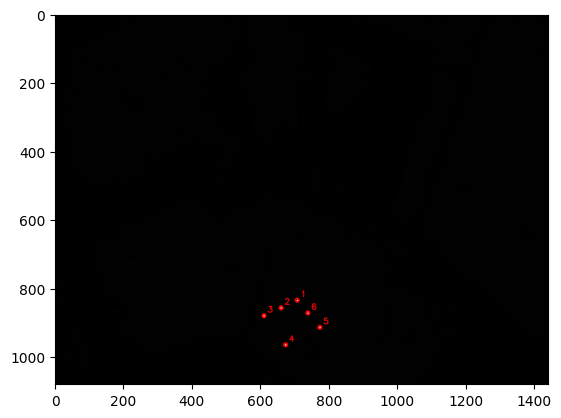

################################################################
CAMERA ID: 127

IMAGE SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
MARKERS:
[[ 882.769231  800.153846]
 [ 845.000000  827.307692]
 [ 807.266667  853.666667]
 [ 964.812500  866.187500]
 [ 847.588235  889.117647]
 [ 890.250000  926.250000]]

SORTED:
[[ 807.266667  853.666667]
 [ 847.588235  889.117647]
 [ 890.250000  926.250000]
 [ 964.812500  866.187500]
 [ 882.769231  800.153846]
 [ 845.000000  827.307692]]



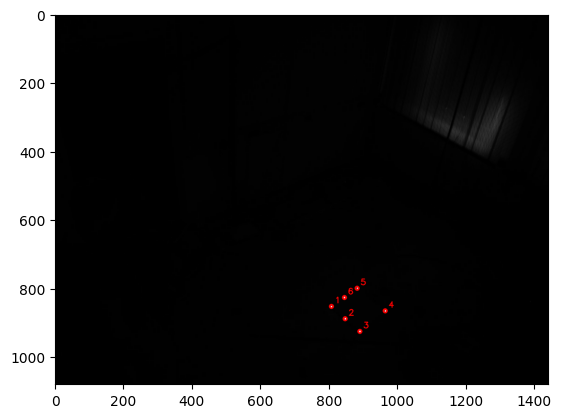

################################################################
CAMERA ID: 135

IMAGE SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
MARKERS:
[[ 658.166667  468.166667]
 [ 734.875000  518.125000]
 [ 582.500000  528.500000]
 [ 697.833333  549.833333]
 [ 621.000000  555.500000]
 [ 659.285714  583.000000]]

SORTED:
[[ 659.285714  583.000000]
 [ 697.833333  549.833333]
 [ 734.875000  518.125000]
 [ 658.166667  468.166667]
 [ 582.500000  528.500000]
 [ 621.000000  555.500000]]



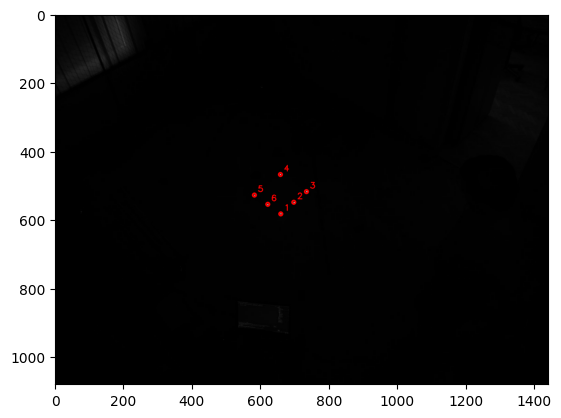

################################################################
CAMERA ID: 143

IMAGE SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
MARKERS:
[[ 658.000000  904.200000]
 [ 695.875000  940.875000]
 [ 568.090909  954.636364]
 [ 734.000000  978.800000]
 [ 692.000000 1006.500000]
 [ 644.384615 1036.615385]]

SORTED:
[[ 734.000000  978.800000]
 [ 695.875000  940.875000]
 [ 658.000000  904.200000]
 [ 568.090909  954.636364]
 [ 644.384615 1036.615385]
 [ 692.000000 1006.500000]]



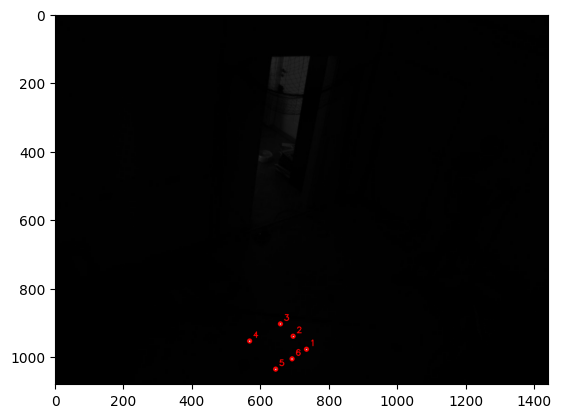

################################################################################################################################
DETECTION

################################################################
CAMERA ID: 151

IMAGE SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
MARKERS:
[[ 727.500000  708.500000]
 [ 684.000000  723.800000]
 [ 638.200000  740.000000]
 [ 753.875000  740.125000]
 [ 782.500000  775.500000]
 [ 689.875000  811.875000]]

SORTED:
[[ 727.500000  708.500000]
 [ 684.000000  723.800000]
 [ 638.200000  740.000000]
 [ 689.875000  811.875000]
 [ 782.500000  775.500000]
 [ 753.875000  740.125000]]



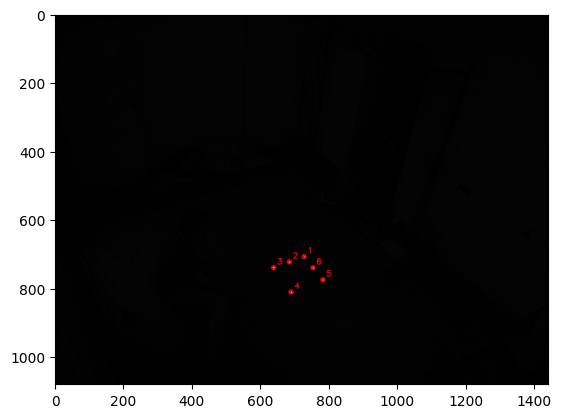

ESTIMATED DIMENSIONS:
0 : [   0.000000    0.177304    0.357682    0.515226    0.364392    0.178361]
1 : [   0.177304    0.000000    0.180379    0.410317    0.402533    0.250276]
2 : [   0.357682    0.180379    0.000000    0.365797    0.505986    0.397964]
3 : [   0.515226    0.410317    0.365797    0.000000    0.356312    0.406706]
4 : [   0.364392    0.402533    0.505986    0.356312    0.000000    0.186040]
5 : [   0.178361    0.250276    0.397964    0.406706    0.186040    0.000000]

ERRORS:

0 : [  -0.392853   -0.451949    0.598825]
1 : [  -0.390910   -0.463249    0.606144]
2 : [  -0.385873   -0.474351    0.611479]
3 : [  -0.357784   -0.459634    0.582471]
4 : [  -0.363483   -0.438742    0.569750]
5 : [  -0.379766   -0.449069    0.588120]

MSE: [   0.927575    1.117715    1.452474]

################################################################
CAMERA ID: 127

IMAGE SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
MARKERS:
[[ 708.200000  797.500000]
 [ 662.750000  822.333333]
 [ 618.0

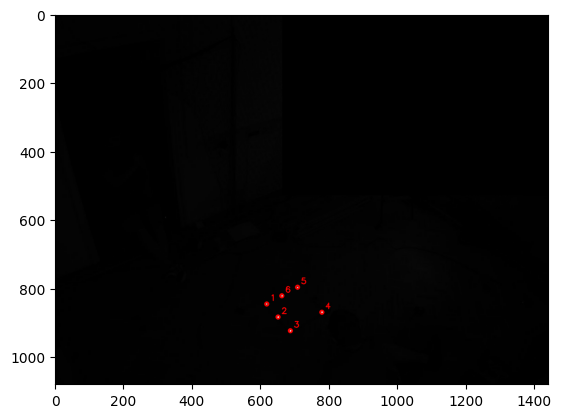

ESTIMATED DIMENSIONS:
0 : [   0.000000    0.180629    0.363138    0.510383    0.354089    0.171143]
1 : [   0.180629    0.000000    0.182511    0.401094    0.395672    0.246446]
2 : [   0.363138    0.182511    0.000000    0.354272    0.503332    0.397877]
3 : [   0.510383    0.401094    0.354272    0.000000    0.362047    0.407029]
4 : [   0.354089    0.395672    0.503332    0.362047    0.000000    0.182956]
5 : [   0.171143    0.246446    0.397877    0.407029    0.182956    0.000000]

ERRORS:

0 : [  -0.401947   -0.438298    0.594699]
1 : [  -0.396818   -0.451723    0.601263]
2 : [  -0.389713   -0.463893    0.605865]
3 : [  -0.360469   -0.460830    0.585066]
4 : [  -0.371630   -0.435509    0.572518]
5 : [  -0.385969   -0.442903    0.587482]

MSE: [   0.942295    1.099796    1.448265]

################################################################
CAMERA ID: 135

IMAGE SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
MARKERS:
[[ 678.875000  602.125000]
 [ 760.111111  667.333333]
 [ 591.8

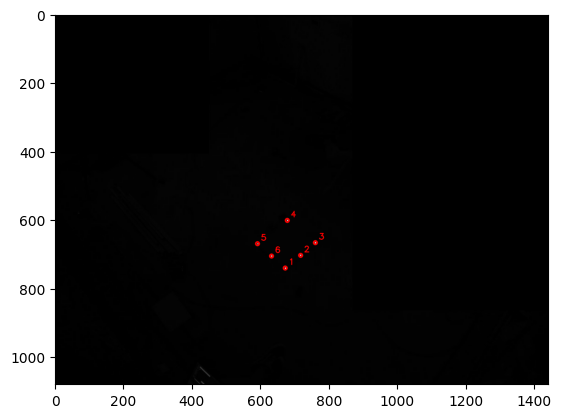

ESTIMATED DIMENSIONS:
0 : [   0.000000    0.174216    0.351714    0.499866    0.357419    0.174799]
1 : [   0.174216    0.000000    0.177499    0.397763    0.397807    0.247373]
2 : [   0.351714    0.177499    0.000000    0.356513    0.501588    0.393392]
3 : [   0.499866    0.397763    0.356513    0.000000    0.350580    0.395329]
4 : [   0.357419    0.397807    0.501588    0.350580    0.000000    0.182622]
5 : [   0.174799    0.247373    0.393392    0.395329    0.182622    0.000000]

ERRORS:

0 : [  -0.387501   -0.433132    0.581171]
1 : [  -0.388627   -0.444038    0.590085]
2 : [  -0.386462   -0.454919    0.596912]
3 : [  -0.365709   -0.449011    0.579098]
4 : [  -0.365559   -0.426387    0.561640]
5 : [  -0.377383   -0.433626    0.574847]

MSE: [   0.927543    1.078505    1.422500]

################################################################
CAMERA ID: 143

IMAGE SHAPE: (1080, 1440, 3)
MARKERS SHAPE: (6, 3)
MARKERS:
[[ 844.090909  916.363636]
 [ 882.300000  952.700000]
 [ 762.0

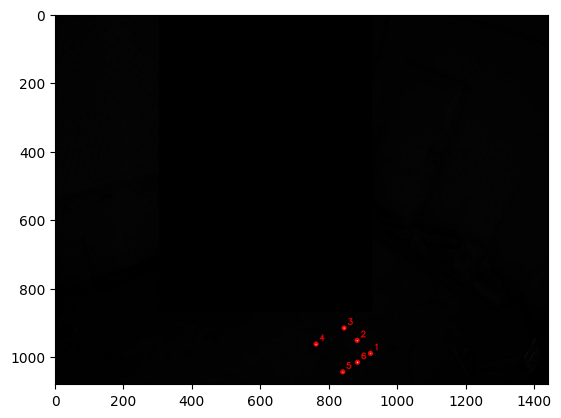

ESTIMATED DIMENSIONS:
0 : [   0.000000    0.172400    0.348035    0.506105    0.367704    0.181063]
1 : [   0.172400    0.000000    0.175635    0.406635    0.405066    0.250240]
2 : [   0.348035    0.175635    0.000000    0.365974    0.504552    0.392581]
3 : [   0.506105    0.406635    0.365974    0.000000    0.347056    0.395736]
4 : [   0.367704    0.405066    0.504552    0.347056    0.000000    0.186653]
5 : [   0.181063    0.250240    0.392581    0.395736    0.186653    0.000000]

ERRORS:

0 : [  -0.373425   -0.460781    0.593098]
1 : [  -0.376190   -0.468314    0.600697]
2 : [  -0.375719   -0.475925    0.606358]
3 : [  -0.358249   -0.460368    0.583336]
4 : [  -0.354897   -0.443544    0.568052]
5 : [  -0.365843   -0.454876    0.583741]

MSE: [   0.900147    1.128594    1.443603]

################################################################
RECREATE PATTERN



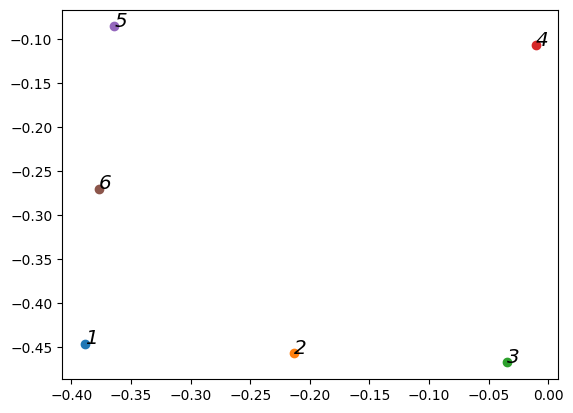


COORDINATES:

[  -0.388932   -0.446040]
[  -0.213136   -0.456831]
[  -0.034442   -0.467272]
[  -0.010553   -0.107461]
[  -0.363892   -0.086046]
[  -0.377241   -0.270118]

INNER DIMS:

0 : [   0.000000    0.176126    0.355125    0.507746    0.360864    0.176309]
1 : [   0.176126    0.000000    0.178999    0.403856    0.400261    0.248580]
2 : [   0.355125    0.178999    0.000000    0.360604    0.503856    0.395450]
3 : [   0.507746    0.403856    0.360604    0.000000    0.353988    0.401145]
4 : [   0.360864    0.400261    0.503856    0.353988    0.000000    0.184556]
5 : [   0.176309    0.248580    0.395450    0.401145    0.184556    0.000000]

ERRORS:

[   0.000000   -0.001126   -0.005125   -0.012772   -0.010864   -0.001309]
[  -0.001126    0.000000   -0.003999   -0.012544   -0.008949   -0.001092]
[  -0.005125   -0.003999    0.000000   -0.010604   -0.008881   -0.004138]
[  -0.012772   -0.012544   -0.010604    0.000000   -0.003988   -0.009833]
[  -0.010864   -0.008949   -0.008881   -0

In [5]:
get_camera_params()
get_markers_from_images()
get_pose_from_cameras()